# Estimating Covariance Structures
Last week, we saw that we can model repeated measures probabilistically by making using of the *multivariate* normal distribution. Key to this, was the specification of the variance-covariance matrix, which captures the pattern of correlation across the repeated measurements. We also saw that one of the problems with the repeated measures ANOVA was that it assumed a very restrictive covariance structure in the form of *compound symmetry* (more generally, *sphericity*). This had direct consequences for inference because the covariance structure directly informs the standard errors and thus the denominator of the tests statistics, the $p$-values and confidence intervals. So, much of our concern around repeated measures is about using a more suitable covariance structure to represent our data-generating process. In an ideal world, what we want is a method that makes *no* assumptions about the covariance structure and just allows it to be estimated from the data. Unfortunately, this desire has consequences for inference. In short, the condition of compound symmetry is imposed for the repeated measures ANOVA *precisely* because that is the one situation where the results simplify back to classical form and inference still works. As soon as we move away from this to an *arbitrary covariance structure*, the inferential machinery *falls apart*. In this part of the lesson, our focus will be on understanding this situation because it has direct consequences for all the methods we will cover going forward. 

## The Basic Problem
Recall that we refer to the variance–covariance matrix as $\boldsymbol{\Sigma}$, as a direct analog of the single variance term $\sigma^{2}$ from the normal linear model. Conceptually, $\boldsymbol{\Sigma}$ plays the same role, describing the scale and structure of the noise in the data. From a mathematical point of view, the natural generalisation of everything we have done so far is to simply replace $\sigma^{2}$ with $\boldsymbol{\Sigma}$ in the expressions used for the normal linear model. When $\boldsymbol{\Sigma}$ is known, this causes no fundamental difficulties. $\boldsymbol{\Sigma}$ behaves like a constant object, introducing no additional randomness, and the underlying theory remains intact. In this sense, moving from a single variance to a full covariance matrix does not, by itself, create any new problems. As we will see later, a known $\boldsymbol{\Sigma}$ can be used to *remove* the correlation structure from the data, allowing us to work in a world that is mathematically indistinguishable from the independent case.

However, the reality is that we will *almost never* know $\boldsymbol{\Sigma}$ *a priori*. As such, we will almost always be in a position where we need to *estimate* it from the data. Once we do that, the term $\boldsymbol{\Sigma}$ is no longer a *fixed constant*. Instead, we have $\hat{\boldsymbol{\Sigma}}$, which is a *random variable*. This introduces an additional layer of uncertainty that causes some major issues. We will discuss the full story below, but the short version is that treating $\hat{\boldsymbol{\Sigma}}$ as an *estimate* means we no longer know how the standard errors are distributed, which means we do not know what null distribution the test statistics have and cannot calculate a $p$-value. In short, *all our inferential machinery breaks*.

## How Estimating $\boldsymbol{\Sigma}$ Breaks Inference
We are going to spend a bit of time discussing the reasons *why* having an arbitrary covariance structure causes the classical inference techniques to fall apart. This is a bit of a detour and can get a little complicated. However, stick with it, because by the end you will have a clearer sense of why our *desire* to have an unstructured covariance matrix does not actually gel with the classical inferential machinery. This is important going forward, because we need to recognise that all the models we will discuss have this problem. Classical inference is *fragile* and as soon as we step outside a very fixed structure, it will break.

### Revisiting the Normal Linear Model
To start understanding why an arbitrary covariance structure is problematic, we need to go back to some of the information covered last semester on [Statistical Inference](https://pchn63101-advanced-data-skills.github.io/Inference-Linear-Model/2.estimation-uncertainty.html). Focusing on the normal linear model, we start from the position of assuming we know what $\sigma^{2}$ is. If this is true, then the standard errors of the parameter estimates are a *constant* quantity. If the assumptions of the model are met, then the parameter estimates have a known distribution. For example, a single slope from a typical regression model has the distribution

$$
\hat{\beta}_{1} \sim \mathcal{N}\left(\beta_{1}, \frac{\sigma^{2}}{\sum{(x_{i} - \bar{x})^{2}}}\right).
$$

The standard error is just the square-root of this variance term

$$
\text{SE}\left(\hat{\beta}_{1}\right) = \sqrt{\frac{\sigma^{2}}{\sum{(x_{i} - \bar{x})^{2}}}}
$$

which depends upon knowing $x$ (the associated predictor variable) and $\sigma^{2}$. This becomes important when we form a test statistic and want to know its null distribution. In the case where $\sigma^{2}$ is a *constant* then the standard error is *also constant*. This means that if we calculate 

$$
z = \frac{\hat{\beta}_{1}}{\text{SE}\left(\hat{\beta}_{1}\right)},
$$

we are just dividing a random variable by a constant. This does not change its distribution, only its *scale*. So, under the null hypothesis that $\beta_{1} = 0$, the null distribution of $z$ is 

$$
z \sim \mathcal{N}(0,1).
$$

This is exactly how inference was conducted before Student came along, with statisticians effectively treating the variance *as if it were known*. 

So, what happens in the more *realistic* scenario when $\sigma^{2}$ is *not* known, and must be replaced by its estimate $\hat{\sigma}^{2}$? Well, the main change is that the *standard errors* also become *estimates*

$$
\widehat{\text{SE}}\left(\hat{\beta}_{1}\right) = \sqrt{\frac{\hat{\sigma}^{2}}{\sum{(x_{i} - \bar{x})^{2}}}}, 
$$

which means that our test statistic is no longer a simple *scaling* of $\hat{\beta}_{1}$. Instead, it now has the form

$$
t = \frac{\hat{\beta}_{1}}{\widehat{\text{SE}}\left(\hat{\beta}_{1}\right)}.
$$

This is a ratio between *two* random variables. Using an *estimate* of the standard error adds an additional layer of uncertainty, because now both the *numerator* and *denominator* will change with each new sample. This additional uncertainty needs to be accommodated. In order to do this, we need to know the *sampling distribution* of $\hat{\sigma}^{2}$. 

We glossed-over this last semester, but under the normal linear model the variance estimate has the following sampling distribution

$$
\hat{\sigma}^{2} \sim \frac{\sigma^{2}}{\nu}\chi^{2}(\nu)
$$

This is a scaled $\chi^{2}$ distribution with $\nu$ degrees of freedom, which is likely unfamiliar to you. However, understanding this distribution is *crucial* for understanding several key ideas 

1. Where the $t$-distribution comes from
2. Where the concept of *degree of freedom* come from
3. How degrees of freedom function as a method of quantifying uncertainty
4. Why everything collapses once we move from a single variance term to an arbitrary covariance matrix.

 Because of this, we will stick to this topic for a little bit longer before getting back to the point of this section. 

### Understanding the Scaled $\chi^{2}$ Distribution
In order to understand the scaled $\chi^{2}$ distribution, we need to first understand the *regular* $\chi^{2}$ distribution. This is written, for some random variable $Y$, as

$$
Y \sim \chi^{2}(\nu).
$$

Notice here that this distribution only has a *single* parameter, $\nu$, called the *degrees of freedom*. This terminology arises because the $\chi^{2}(\nu)$ is the distribution of the sum-of-squares calculated from $\nu$ standard normal variates[^chisq-foot]. So $\nu$ is literally the count of the number of random variables that form this sum. What this means is that both the *mean* and *variance* are functions of $\nu$. So, we have

$$
\begin{alignat*}{1}
    E(Y)          &= \nu \\
    \text{Var}(Y) &= 2\nu.
\end{alignat*}
$$

Some example $\chi^{2}$ distributions for different values of $\nu$ are shown below

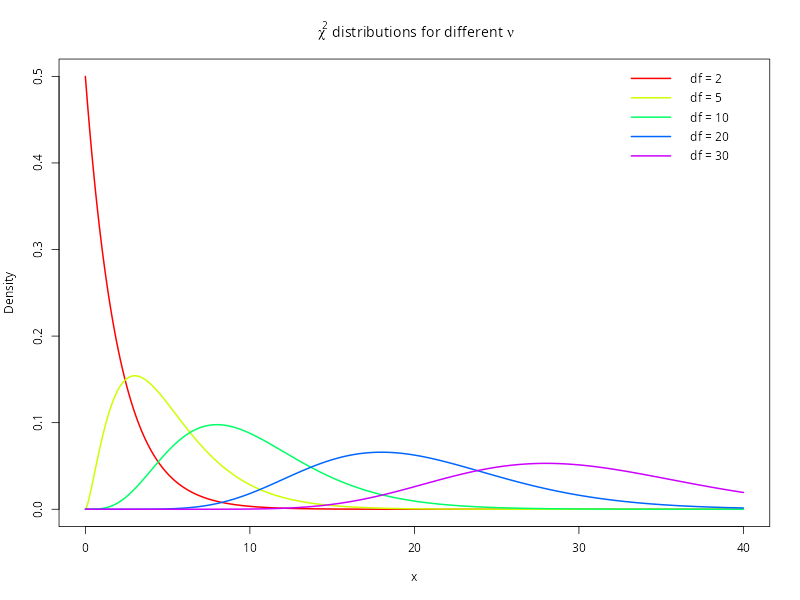

In [1]:
# Plot several chi-square distributions on the same axes

dfs <- c(2, 5, 10, 20, 30)
x <- seq(0, 40, length.out = 2000)

# Compute densities
densities <- lapply(dfs, function(nu) dchisq(x, df = nu))

# Set up empty plot with sensible limits
ymax <- max(unlist(densities))
plot(x, densities[[1]], type = "n",
     xlab = expression(x),
     ylab = "Density",
     main = expression(chi^2 * " distributions for different " * nu))

cols <- rainbow(length(dfs))

# Add each curve
for (i in seq_along(dfs)) {
  lines(x, densities[[i]], col = cols[i], lwd = 2)
}

legend("topright",
       legend = paste("df =", dfs),
       col = cols,
       lwd = 2,
       bty = "n")


Notice that $\nu$ controls the *width* of the distribution. Thus, the *uncertainty* around the value of $X$ can be quantified using $\nu$. This is very important for understanding *where* degrees of freedom come from. 

However, because $\nu$ also controls the *mean*, we have a slight problem. As a sampling distribution for $\hat{\sigma}^{2}$, we can get the *shape* correct by using a suitable value for $\nu$. However, this will not necessarily be *scaled* correctly. For instance, $\chi^{2}(5)$ may well have the right *width* to capture the uncertainty in $\hat{\sigma}^{2}$, but the expected value is then $\nu = 5$. This would only work with data on a scale where $\sigma^{2} = 5$. So, the sampling distribution of $\hat{\sigma}^{2}$ *cannot* be a plain old $\chi^{2}(\nu)$ distribution, because the units would be wrong. Therefore, the actual sampling distribution must be a *scaled* version of the $\chi^{2}(\nu)$. 

To see how this scaling works, notice that if we were to multiply the whole distribution by $\sigma^{2}$, then the expected value would be $\sigma^{2} \times \nu$. This is obviously $\nu$-times too big. So if we first *divide* $\sigma^{2}$ by $\nu$, then the expected value becomes $\frac{\sigma^{2}}{\nu} \times \nu = \sigma^{2}$. We then end up with a distribution with the correct *width* (encoded by the *degrees of freedom*) and the correct *units* (by scaling the distribution by $\sigma^{2}/\nu$). So, the scaling term is a little bit of a distraction here. The key element is that *the degrees of freedom are a direct measure of our uncertainty around the estimate of $\sigma^{2}$*.

As $\nu$ is directly tied to the *sample size* (because $\nu = n - p$), as $n$ increases, so too does $\nu$. So, let us have a look and see what happens to the scaled $\chi^{2}$ as we increase $n$ and thus increase $\nu$. Below are 6 plots demonstrating what happens to the *shape* of scaled $\chi^{2}$ distribution as the sample size increases.

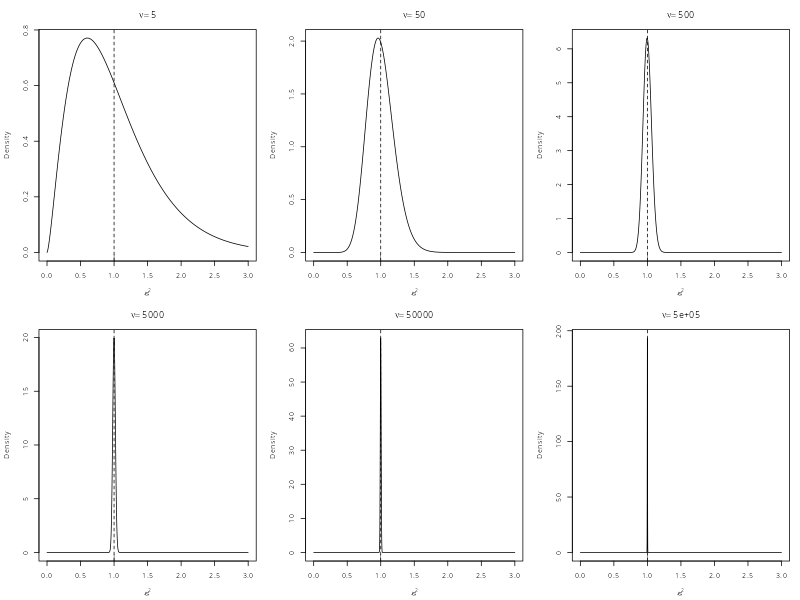

In [2]:
# Visualise the scaled chi-square variance estimator:
#   s2_hat = (sigma2 / nu) * X,  where X ~ chisq(nu)
# so s2_hat is centred on sigma2 and collapses onto sigma2 as nu grows.

sigma2 <- 1
dfs <- c(5, 50, 500, 5000, 50000, 500000)

# Density of s2_hat via change-of-variables:
# If S = (sigma2/nu) X, then f_S(s) = (nu/sigma2) * f_X((nu/sigma2)*s)
d_scaled_chisq <- function(s, nu, sigma2) {
  (nu / sigma2) * dchisq((nu / sigma2) * s, df = nu)
}

# Choose an x-range that makes the "collapse" obvious
x <- seq(0, 3, length.out = 2000)

# Pre-compute a common y-limit so all plots are comparable
ymax <- max(sapply(dfs, function(nu) max(d_scaled_chisq(x, nu, sigma2))))

op <- par(mfrow = c(2,3), mar = c(4, 4, 3, 1) + 0.1)
on.exit(par(op), add = TRUE)

for (nu in dfs) {
  y <- d_scaled_chisq(x, nu, sigma2)

  plot(x, y, type = "l",
       xlab = expression(hat(sigma)^2),
       ylab = "Density",
       xlim = c(0,3),
       main = bquote(nu == .(nu)))
  #     main = bquote(frac(sigma^2,nu) * chi^2 * "(" * nu * ")"))

  abline(v = sigma2, lty = 2)          # true variance
  rug(c(sigma2), ticksize = 0.03)
  #legend("topright",
  #       legend = c(bquote(nu == .(nu)), bquote(sigma^2 == .(sigma2))),
  #       bty = "n")
}

# If you want to *really* see the collapse for large nu, try narrowing xlim:
# e.g., set x <- seq(0.6, 1.4, length.out=2000) and xlim=c(0.6,1.4)


So, notice what happens. As the degrees of freedom go up, the width of the scaled $\chi^{2}$ distribution *shrinks*. When the same size is *small*, there is a lot of uncertainty around the true value of $\sigma^{2}$. When the sample size gets *large*, this uncertainty gets smaller and smaller until it effectively *vanishes*. So, the degrees of freedom exist *precisely* because they are the parameter of the sampling distribution that quantified our uncertainty about $\hat{\sigma}^{2}$. Once they get larger enough, the distribution is effectively a single point sat on the true variance and, for all practical purposes, we *know* $\sigma^{2}$.

So, how does this connect to the null distribution of the test statistic? Well, what happens when you divide a normal random variate and a scaled $\chi^{2}$ random variate? You get a new random variable that has a $t$-distribution with $\nu$ degrees of freedom. So, the definition of the $t$-distribution is *exactly* the ratio between these two types of random variable. *This is where the $t$-distribution comes from*. The uncertainty in the denominator is passed *directly* through to the $t$-distribution, which uses $\nu$ to alter its shape dynamically with sample size. So the degrees of freedom in the $t$-distribution come directly from the degrees of freedom in the scaled $\chi^{2}$ distribution. As sample size goes up, $\nu$ also goes up, the scaled $\chi^{2}$ collapsed to a single point and $\hat{\sigma}^{2} = \sigma^{2}$. At this point, the $t$-statistic is effectively dividing a random variable by a *constant* and the $t$-distribution becomes the standard normal distribution. Indeed, a $t$-distribution with infinite degrees of freedom *is* the standard normal distribution. So, once the degrees of freedom get large enough to be taken as *effectively infinite*, they basically *disappear* because they are no longer needed as a method of quantifying uncertainty. This is because our uncertainty has collapsed to 0 and we are back to our original position of treating $\sigma^{2}$ as a constant and using $z \sim \mathcal{N}(0,1)$ for inference. This is why most of these problems disappear with large samples.

### What Happens When We Use $\hat{\boldsymbol{\Sigma}}$?
We have now established what happens when we use an *estimate* of ${\sigma}^{2}$ within the context of the normal linear model. Crucially, this depended upon knowing the *sampling distribution* of $\hat{\sigma}^{2}$ in order to derive the *null distribution* of the test statistic. Given that this null distribution is used to calculate both *confidence intervals* and $p$-values, it becomes essential to have all this information to hand. 

So, what happens when we have a complex variance-covariance matrix $\boldsymbol{\Sigma}$, rather than a single variance term $\sigma^{2}$? Well, the standard errors will no longer depends upon *a single variance term*. Instead, they will be complex functions of different elements of the variance-covariance matrix. As we saw above, the distribution of the test statistic depended upon knowing the distribution of the variance estimate which, under the normal linear model, was a scaled $\chi^{2}(\nu)$ distribution. So what distribution do we get when working with complex variance functions derived from an estimated variance-covariance matrix? Herein lies the problem. *We do not know*.

When we have complex dependencies in the data, all the clean algebra disappears and the distribution can no longer be derived analytically. As stated above, the $\chi^{2}(\nu)$ distribution comes from summing *independent* values. Under the normal linear model, the errors are *independent* and thus the variance estimate formed from their sum fits the $\chi^{2}$ definition. As we will come to see, methods that allow for more complex covariance structures can be conceptualised as *removing* the correlational structure from the data and returning us back to the world of the normal linear model. If we knew $\boldsymbol{\Sigma}$ ahead of time, this removal would be *perfect* and the errors would be guaranteed independent. The $\chi^{2}$ definition would therefore fit. However, when we have an *estimate* of $\boldsymbol{\Sigma}$, this removal will be *imperfect*. Thus, the errors will still not be independent and the $\chi^{2}(\nu)$ distribution no longer applies. 

We might think that the $\chi^{2}$ would still apply *approximately*, but unfortunately the definition of "approximately" will change with every sample. This is because each sample will be unique in how close or how far it is to the true value of $\boldsymbol{\Sigma}$. Therefore, there is no longer a universal $\chi^{2}(\nu)$ distribution that fits across all samples. We have no way of capturing uncertainty in a way that is true no matter the data. In effect we have *no sampling distribution left*. Whatever distribution we can calculate is a *moving target* and classical inference hits a brick wall. What this means is that the scaled $\chi^{2}(\nu)$ distribution is no longer applicable as a universal description of how the variance estimate would behave across samples. Once this disappears, so too does the concept of degrees of freedom as a universal description of uncertainty. So, the issue here is not computational, it is conceptual:

- With known $\boldsymbol{\Sigma}$, sampling distributions, null distributions and $p$-values refer to a population-level, repeatable experiment.
- With estimated $\boldsymbol{\Sigma}$, they become conditional on the *one dataset* in front of you.

So, these quantities are no longer describing how the statistic would behave *across samples*, which is exactly what they are supposed to do in order to make classical inference work. Our conclusions would be conditional on the covariance structure this one particular dataset happened to produce and therefore do not cleanly apply to any other dataset with a different covariance structure, nor the population at large. The whole purpose of our inference is gone.

## Practical Solutions to this Problem

So, we find ourselves in a difficult spot. What we *want* is a framework where we can have any form of covariance structure to accurately represent the data-generating process. This would allow us to model any type of repeated measures experiment, irrespective of its complexity. However, the inferential devices used by the normal linear model simply *do not allow this*. The emphasis on *knowing* the distribution of the estimates in order to calculate $p$-values and confidence intervals has backed us into a corner. Once the very specific conditions that allow these to be calculated are gone, so is the whole exact inferential machinery. This demonstrates how *fragile* these methods really are. 

However, methods that allow for a more general covariance structure *do* exist. So how do we use them *practically* to try and reach conclusions? Here, we need to separate the idea of *model building* from *inference*. As a means of developing a description of the *data-generating process*, methods that allow for a more general covariance structure are much more applicable than those with very restrictive definitions. As such, we can develop much better *models* that describe *where the data came from* and the *relationships* that capture this. The problem, of course, is performing *inference* using those models. So we have *better models* that we want to use, but *complexities* around reach exact conclusions from these. As such, the compromise is that as soon as we leave the world of the normal linear model, our inference *has to become approximate*. This can be an uncomfortable conclusion, but it is reality. So, how do we deal with this issue *practically* so we can still use these methods?

### Option 1 - Pretend the covariance structure is known


#### Just assume $\hat{\boldsymbol{\Sigma}} = \boldsymbol{\Sigma}$
Our first option is to *ignore* the problem. If we treat our estimate as *exactly* the population value, then we can carry on without any issues. So, if we take $\hat{\boldsymbol{\Sigma}} = \boldsymbol{\Sigma}$ then there are no problems any more. In the context of GLS, this means we can remove the covariance structure *perfectly* and the whole problem reduces back to a regular regression model with $i.i.d.$ errors. So, we simply act as if we knew $\boldsymbol{\Sigma}$ all along.

Although this is *practically* appealing, because all the mess indicated above disappears, it comes with some consequences:

- The extra uncertainty from estimating $\boldsymbol{\Sigma}$ is simply ignored. This means the model contains no penalty for estimating all the variance and covariance parameters.
- This means that standard errors may be too small, test statistics too large and $p$-values overly-optimistic, especially in small samples.
- We are pretending that degrees of freedom exist as a universal marker of uncertainty, but they technically do not. Furthermore, because we are pretending that we got $\boldsymbol{\Sigma}$ for free, the degrees of freedom have no correction for estimating $\boldsymbol{\Sigma}$. As such, they will be *larger* than equivalent repeated measures ANOVA models.

#### Lean on *asymptotic* results
Our third option is to side-step degrees of freedom entirely. Recall from the normal linear model that the uncertainty that comes from estimating $\sigma^{2}$ effectively *disappears* once the same size is large enough. This is because $\hat{\sigma}^{2} = \sigma^{2}$, for all practical purposes. Thus, we can treat everything as if $\sigma^{2}$ is known, because our uncertainty is effectively 0. We saw this in the shape of the $t$-distribution. Once the sample size is big enough, the $t$-distribution *becomes* a standard normal distribution whose width is fixed, rather than adaptive. When this happens, the degrees of freedom disappear. So, whilst we normally work with something like

$$
\frac{\hat{\beta}_{1}}{\text{SE}(\hat{\beta}_{1})} \sim \mathcal{T}(\nu),
$$

it is not wrong to work with

$$
\frac{\hat{\beta}_{1}}{\text{SE}(\hat{\beta}_{1})} \sim \mathcal{N}(0,1).
$$

The only caveat is that the sample size needs to be *big enough* for the second option to be accurate. However, notice that this second option *does not need degrees of freedom*. We say that this test is *asymptotically correct*, meaning it gets more accurate as $n \rightarrow \infty$. All we need to do is make the assumption that we have enough data so that we can effectively treat our estimate of $\sigma^{2}$ as the *true value*. At that point it becomes a *constant*. So, there is no uncertainty to deal with, no sampling distribution to know, no concept of degrees of freedom and all the messiness disappears.

Although such asymptotic approaches are not necessary with the normal linear model, once we are in the realm of estimating a complex covariance structure this approach becomes more appealing. There is a *statistical purity* to this result because we do not need to pretend degrees of freedom still exist nor invent fictitious degrees of freedom based on the model. However, there are some clear issues here

- We need to be comfortable assuming that our $n$ is *large-enough* for this to work, but this is an *unanswerable* question (see box below).
- We need to be comfortable with the idea of dismissing uncertainty in the estimation of $\boldsymbol{\Sigma}$ as negligible.
- In small samples this will result in inference that is *optimistic*, though the open use of asymptotic tests already embeds this as a caution.

`````{admonition} How Large is "Large"?
:class: tip
If we want to lean on asymptotic theory, the obvious question is "how big does $n$ need to be?". The problem is that the definition is based on a *limit*, so it says that the approximation gets better and better as $n$ moves towards infinity. For our purpose, $n$ is the *number of subjects*, rather than the total amount of data. So, the answer is not that there is some magic sample size that is suddenly large enough, the answer is that the approximation will get better the larger $n$ becomes. The question then is more about what our tolerance for error is. The point of the asymptotic theory is to say that the error that comes from estimation becomes more negligible as $n$ grows, as does the penalty for estimating $\boldsymbol{\Sigma}$ from the data. So, unfortunately, there is *no honest numeric answer to this question*. The way to think about it is as a *degree of comfort*. If you are using FGLS with $n = 5$, you should feel *very uncomfortable*. If you are using $n = 50$, you should probably feel *cautious* and if you have $n > 200$ you should probably be feeling *reasonably comfortable*. As $n$ increases beyond that, you should probable feel perfectly fine about this approach. These are only ballpark figures, but the point is really to think of $n$ as a *continuum of comfort*, rather than as a *threshold*. 
`````

#### Use simulation methods
The advantage here is that we do not assume the uncertainty around estimating $\boldsymbol{\Sigma}$ has a particular shape. Yes, we fix the value estimated from the data as the "truth", but the uncertainty around that "truth" is still captured via the simulations. This means we do not assume this uncertainty will have a particular sampling distribution, we let the simulations build the distribution over its many iterations. This neither requires assuming that the classical results still hold, nor requires enough data so that all these problems disappear.  

As a final option, we can leave the world of trying to derive precise results mathematically and instead use the power of the *computer* to find a solution. This gets us into the world of *resampling methods*, which we encountered briefly last semester in the form of the *permutation test*, used when the errors are not normally distributed. For the general problem of deriving a null distribution under an arbitrary covariance structure, the *parametric bootstrap* is most commonly employed. In this method we:

1. Treat a fitted null model as the "truth".
2. Use this fitted model to simulate new data.
3. Refit the model to the simulated dataset and save a copy of the test statistic.
4. Over many repeats of 2 and 3, build up a *distribution* of the test statistic under the null.
5. Calculate the $p$-value and confidence intervals from this distribution.

So this requires *zero* theory about the distribution of anything. The uncertainty comes through naturally as part of the simulation and we can get a $p$-value irrespective of the form of $\boldsymbol{\Sigma}$. So this has some distinct advantages because we can get rid of much of the difficult approximation needed in classical approaches. However, the tradeoffs are

- Computational burden, as calculating a single $p$-value can be a long process depending upon the complexity of refitting the model 1,000 times or more.
- Fundamentally, we have to assume that our models is a close approximation to the truth for this to work. This can be seen as quite a *strong* assumption.


### Option 2 - Acknowledge the covariance structure is *unknown*, and try to correct for it
Our second option is to accept that $\hat{\boldsymbol{\Sigma}}$ is an estimate and accept that we need to accommodate this uncertainty somehow. In order to do this, we can create *fictitious* degrees of freedom to allow a $p$-value to be calculated. So, although we fully accept that degrees of freedom no longer exist, what we can do is *find* a null distribution that matches our model and then use the degrees of freedom from that distribution. For instance, we can use a combination of heuristics and information in the model to approximate the *variance* of the calculated test statistic. If we know that the variance of the $t$-distribution is $\frac{\nu}{\nu - 2}$, then we can use our approximated variance to solve for $\nu$. This gives us a $t$-distribution with approximately the *correct width* for our calculated test statistic. These fictitious degrees of freedom are known as *effective* degrees of freedom. They attempt to capture *universal uncertainty* in the same way that traditional degrees of freedom do, but within a context where this definition is no longer applicable.

This method is perhaps more appealing than simply pretending there is no problem because it tried to accommodate small sample adjustments and uncertainty, though it also comes with some consequences:

- We are assuming that the true null distribution only differs from known null distributions (such as the $t$ and $F$) by its width, but not the general shape.
- This still remains an *approximation*, though it should behave better in smaller samples when degrees of freedom become more necessary.
- Degrees of freedom can become fractional and no longer have a clear theoretical grounding. They are more devices to encode "tail-heaviness" within the familiar language of $t$ and $F$ distributions. 

In fact, we already saw an example of this last week in terms of the *non-sphericity corrections*.

## Covariance Constraints
As well as understanding that the very process of estimating $\boldsymbol{\Sigma}$ causes problems, we also need to understand that we cannot have free reign to estimate any old covariance structure we like. One of the most important elements to recognise is that some sort of *constraint* is always needed when estimating a variance-covariance matrix. To see this, note that for a repeated measures experiment there are $nt \times nt$ values in this matrix. The values above and below the diagonal are a mirror image, so the true number of unknown values is $\frac{nt(nt + 1)}{2}$. For instance, if we had $n = 5$ subjects and $t = 3$ repeated measures, there would be $\frac{15 \times 16}{2} = 120$ unique values in the variance-covariance matrix. If we allowed it to be completely unstructured, we would have 120 values to estimate *just* for the covariance structure. Indeed, this is not really possible unless the amount of data we have *exceeds* the number of parameters. So, the data itself imposes a *constraint* on how unstructured the covariance matrix can be.

Luckily, for most applications, we not only assume that $\boldsymbol{\Sigma}$ has a block-diagonal structure (so most off-diagonal entries are 0), but that many of the off-diagonal elements are actually *identical*. We saw this previously with the repeated measures ANOVA. Even though $\boldsymbol{\Sigma}$ may have *hundreds* of values we *could* fill-in, if we assume compound symmetry only within each subject, there are only *two* covariance parameters to be estimated: $\sigma^{2}_{b}$ and $\sigma^{2}_{w}$. The whole matrix can then be constructed using those two alone. This is an example of *extreme simplification*, but it does highlight that we generally do not estimate the *whole* variance-covariance matrix. We only estimate *small parts* of it. Indeed, making the covariance matrix more general is often a risky move because of the number of additional parameters needed. The more we estimate from the same data, the greater our uncertainty will become because each element of the covariance-matrix is supported by *less data*. Complexity always comes at a price.

`````{admonition} Where Does This All Leave Us?
:class: warning
So, where do these problems leave us in terms of leaving the world of very stringent covariance assumptions?

... Ultimately, from the pure perspective of a *model* that capture the *data-generating process*, FGLS is an attractive proposition ... Unfortunately, the problems arrive as soon as we get to *inference* due to the fragility of the classic approaches to this problem. However, the reality is that as soon as we leave the world of the normal linear model, we leave the world of precise results and always end up in a world of approximations. This is not just a FGLS problem, this is a *global* problem. So if we ever want to use something more complicated than the normal linear model, we have to accept that precise inference breaks-down and we have to approximate it. The fundamental question simply becomes how *best* to approximate it so we can still reach useful conclusions from our models.
`````

[^weights-foot]: This is why the argument in `gls()` was `weights=`.

[^corfunc-foot]: You can look up descriptions of all of these using `?corClasses` at the prompt. 

[^white-foot]: This is sometimes known as *whitening* the data. This is a term you may come across in the neuroimaging literature, particularly in relation to how fMRI is analysed.

[^emmeans-foot]: The `mode=` option has been set to `df.error` so that the reported test matches the table from `summary()`. `emmeans` actually has some better ways of adjusting the degrees of freedom to accommodate the uncertainty in estimating $\boldsymbol{\Sigma}$, but this is a complication we will leave to one side for now.

[^chisq-foot]: Sound suspiciously close to how the variance is estimated from the residuals in a normal linear model?